In [1]:
import setigen_patch as stg # some **kwargs, slightly modified plots, add gamma noise
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u

/home/obs/.conda/envs/seticore/lib/python3.12/site-packages/blimpy/__init__.py:21: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
%matplotlib inline

In [3]:
WINDOW_SIZE = 2**10
OUTPUT_FOLDER = "../../deliverables/injected/"
TEST_OUTPUT = "outputs/v2/"

First I'll define MeerKAT band 5b parameters

In [8]:
df = 1 * u.Hz
num_samples = 2**24
# lo, hi = 15.365*u.GHz, 15.38*u.GHz
lo = 15*u.GHz; hi = lo + num_samples*df
center_freq = (lo+hi)/2
bandwidth = (hi-lo)
obs_time = 300 * u.s
n_ints = 16
# df = bandwidth / num_samples
dt = obs_time / n_ints

dt, df.to(u.Hz), lo, hi, bandwidth

(<Quantity 18.75 s>,
 <Quantity 1. Hz>,
 <Quantity 15. GHz>,
 <Quantity 15.01677722 GHz>,
 <Quantity 0.01677722 GHz>)

In [176]:
frame = stg.Frame(
    fchans=num_samples,
    tchans=n_ints,
    df=df,
    dt=dt,
    fch1=hi,
    dtype=np.float32
)

## Add Noise
### $T_\text{rx}$
for this we have the inequality given in the technical specification:
$$ T_\text{rx} < 10.6 + 0.633\,(\nu - 8.41) $$
at frequency $\nu$. We will treat this as an equality in order to make a worst-scenario estimate

In [177]:
T_rx = lambda nu: 10.6*u.K + 0.633 * (nu - 8.41*u.GHz) * (u.K/u.GHz)

### $T_\text{sky}$

Which is $T_\text{atm} + T_\text{gal} + T_\text{cmb}$ namely the contributions are from respectively atmospheric emission, galactic synchrotron background and cosmic microwave background.

In [178]:
T_sky = lambda nu: 568*u.K * (nu / u.GHz)**-1.13 # galactic center 

In [179]:
T_sys = lambda nu: T_rx(nu) + T_sky(nu)

### Power and error

In [180]:
def power(nu):
    k_B = 1.38e-23 * (u.J/u.K)
    R = 50 * u.Ohm
    P = k_B * T_sys(nu) * frame.df * u.Hz
    P = P.to(u.yW)
    
    N = (frame.df*u.Hz * frame.dt*u.s).to(u.dimensionless_unscaled)

    return P, N
P, N = power(center_freq)

In [181]:
f"Power: {P :.4g} ± {P/np.sqrt(N) :.4g} over {N :.4g} samples"

'Power: 571.2 yW ± 131.9 yW over 18.75 samples'

In [182]:
noise = frame.add_noise(k=(N/2).value, theta=(2*P/N).value, noise_type='gamma')

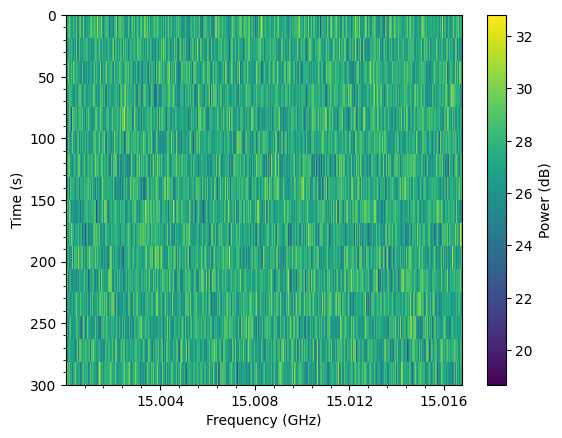

In [170]:
frame.plot('f', minor_ticks=True, db=True, funits="GHz", fdownsample=2**10)

In [171]:
def add_signal(frame, mean_freq, dr, snr, width):
    f_start = mean_freq - dr*frame.data.shape[0]*frame.dt*u.s/2
    
    return frame.add_signal(
        stg.constant_path(f_start=f_start,
                          drift_rate=dr),
        stg.constant_t_profile(level=frame.get_intensity(snr=snr)),
        stg.gaussian_f_profile(width=width),
        stg.constant_bp_profile(level=1)
    )

In [172]:
midf = 15.004*u.GHz ; dr  = 1.5 * (u.Hz/u.s);
width=1*u.Hz       ; snr = 30*u.dimensionless_unscaled

In [174]:
importlib.reload(stg)
import setigen_patch as stg

In [175]:
signal = add_signal(frame, midf, dr, snr, width)

In [20]:
frame_s = frame.get_slice(
    (f := frame.get_index(frequency=midf)) - WINDOW_SIZE//2,
    f + WINDOW_SIZE//2
)

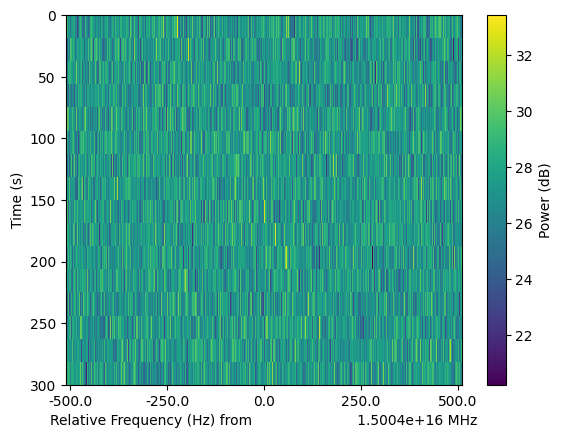

In [21]:
frame_s.plot()

In [22]:
frame.data.dtype = np.float32

In [23]:
frame.save_h5(OUTPUT_FOLDER + "meerKAT_high_30.h5")

blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for ../../deliverables/injected/meerKAT_high_30.h5 without blobbing.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
blimpy.waterfall INFO     Conversion time: 1.71sec


both seticore and turboSETI find the hit:

In [24]:
!HDF5_PLUGIN_PATH=/home/obs/.conda/envs/seticore/lib/python3.12/site-packages/hdf5plugin/plugins seticore {OUTPUT_FOLDER+"meerKAT_high_30.h5"}

welcome to seticore, version 1.0.6
running in dedoppler mode.
loading input from ../../deliverables/injected/meerKAT_high_30.h5
dedoppler parameters: max_drift=10.00 min_drift=0.0000 snr=25.00
writing output to ../../deliverables/injected/meerKAT_high_30.dat
hit: coarse channel = 12, index = 194529, snr = 28.50984, drift rate = 1.50044 (-422 bins)
dedoppler elapsed time: 4s


In [25]:
!turboSETI -g y {OUTPUT_FOLDER+"meerKAT_high_30.h5"}


turbo_seti version 2.3.2
blimpy version 2.1.4
h5py version 3.8.0
hdf5plugin version 4.1.1
HDF5 library version 1.12.2


data_handler    INFO     From blimpy, n_coarse_chan=16
HDF5 header info: {'DIMENSION_LABELS': array(['time', 'feed_id', 'frequency'], dtype=object), 'az_start': 0.0, 'data_type': 1, 'fch1': 15016.777215999999, 'foff': -1e-06, 'ibeam': -1, 'machine_id': 20, 'nbeams': 1, 'nbits': 32, 'nchans': 16777216, 'nifs': 1, 'rawdatafile': 'Synthetic', 'source_name': 'Synthetic', 'src_dej': <Angle -28.3831 deg>, 'src_raj': <Angle 17.7875 hourangle>, 'telescope_id': 6, 'tsamp': 18.75, 'tstart': 60869.65465742104, 'za_start': 0.0}

Starting ET search with parameters: datafile=../../deliverables/injected/meerKAT_high_30.h5, max_drift=10.0, min_drift=1e-05, snr=25.0, out_dir=./, coarse_chans=, flagging=False, n_coarse_chan=16, kernels=None, gpu_id=0, gpu_backend=True, blank_dc=True, precision=1, append_output=False, log_level_int=20, obs_info={'pulsar': 0, 'pulsar_found': 0, 'pulsar_

## A lot of them

In [262]:
importlib.reload(utils.setigen)
import utils.setigen

In [ ]:
from utils.setigen import make_and_save_random
make_and_save_random(
    num_cpus=1,
    signal_per_file=100,
    output_dir=TEST_OUTPUT + "files/",
    signal_info_dir=TEST_OUTPUT + "signals/",
)

## see if seticore detected the signal

In [41]:
from pathlib import Path

out_dir = Path(TEST_OUTPUT)

files_dir = out_dir / "files"
seticore_dir = out_dir / "seticore"
signal_dir = out_dir / "signals"

In [ ]:
def show_found_signal(fr, midf, dr, midf2=None, dr2=None):
    if midf2 is None: midf2=midf
    if dr2 is None: dr2=dr
    i_min = fr.get_index(frequency=-np.abs(dr*150)*u.Hz + min(midf, midf2)*u.GHz) - WINDOW_SIZE//2
    i_max = fr.get_index(frequency=np.abs(dr2*150)*u.Hz + max(midf, midf2)*u.GHz) + WINDOW_SIZE//2
    frame_s = fr.get_slice(i_min, i_max)
    frame_s.plot(ftype="f", funits="MHz")
    plt.plot(
        frame_s.ts_ext * dr + midf*1e9 - dr*(150 + frame_s.dt//2),
        frame_s.ts_ext,
        c='k',
        alpha=.4
    )
    plt.plot(
        frame_s.ts_ext * dr2 + midf2*1e9 - dr2*(150 + frame_s.dt//2),
        frame_s.ts_ext,
        c='r',
        alpha=.7
    )
    plt.show()

In [153]:
def check_signal(signal, seticore, frame=None, verbose=False):
    distances = np.linalg.norm((seticore - signal[:3])[:, :1], axis=1)    
    min_index = np.argmin(distances)

    if verbose:
        print(f"{signal = }")
        print(f"Closest row index: {min_index}")
        print(f"{seticore[min_index] = }")
        print(f"Minimum L2 distance: {distances[min_index]}")

    if frame: show_found_signal(frame, *seticore[min_index, :2], *signal[:2])
    return distances[min_index]

In [154]:
def gets_found(*args, **kwargs):
    return check_signal(*args, **kwargs) < 1e-8

In [184]:
SIGNALS=[]

In [185]:
def process_file(
    f: Path,
    results_signals=SIGNALS,
    seticore_dir=seticore_dir,
    signal_dir=signal_dir,
    show_signal_probability=0,
):
    seticore_f = seticore_dir / (f.stem + ".dat")
    signals_f  = signal_dir   / (f.name + ".npy")
    assert signals_f.exists(), "numpy array with signal info not found"
    assert seticore_f.exists(), "run seticore on the file first"
    signals = np.load(signals_f).T # cols are [mean_freq, dr, snr, width]
    seticore = np.loadtxt(seticore_f) # 
    seticore_like_signals = np.vstack([
        (seticore[:, 6:8].mean(axis=1) * 1e6 + 150 * seticore[:, 1]) * 1e-9,
        seticore[:, 1],
        seticore[:, 2],
    ]).T
    for s in signals:
        frame, verbose = None, None
        if np.random.random() < show_signal_probability:
            frame = stg.Frame(f)
            verbose = True
        results_signals.append(np.array([
            *s,
            gets_found(
                s,
                seticore_like_signals,
                frame,
                verbose
            )
        ]))
    return results_signals

In [186]:
def process_dir(files_dir: Path = files_dir, *args, **kwargs):
    signals = []
    for file in files_dir.iterdir():
        signals = process_file(
            f=file,
            results_signals=signals,
            *args, **kwargs
        )
    return np.array(signals)

In [187]:
f = files_dir / "2181600055872595243.h5"

In [599]:
frame = stg.Frame(f)

In [593]:
sg = signal_dir / (f.name + ".npy")

In [594]:
st = seticore_dir / (f.stem + ".dat")

In [595]:
sg = (np.load(sg).T)[:, :3]

In [596]:
st = np.loadtxt(st)

In [597]:
st_like_sg = np.vstack([
    (st[:, 6:8].mean(axis=1) * 1e6 + 150 * st[:, 1]) * 1e-9,
    st[:, 1],
    st[:, 2],
]).T

signal = array([ 9.13072577,  1.5690012 , 40.18239468])
Closest row index: 91
seticore[min_index] = array([ 9.13072577,  1.550222  , 51.575344  ])
Minimum L2 distance: 1.3366303619477549e-09


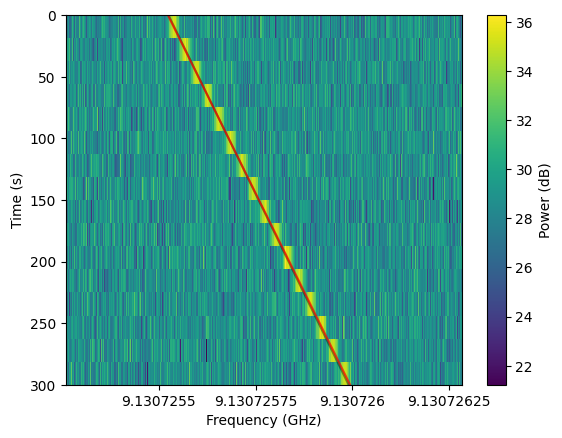

np.float64(1.3366303619477549e-09)

In [600]:
check_signal(sg[89], st_like_sg, frame, verbose=True)

signal = array([ 9.13161005,  1.54309165, 84.48223921])
Closest row index: 38
seticore[min_index] = array([  9.13160714,  -2.830222  , 235.264282  ])
Minimum L2 distance: 2.910932170863134e-06


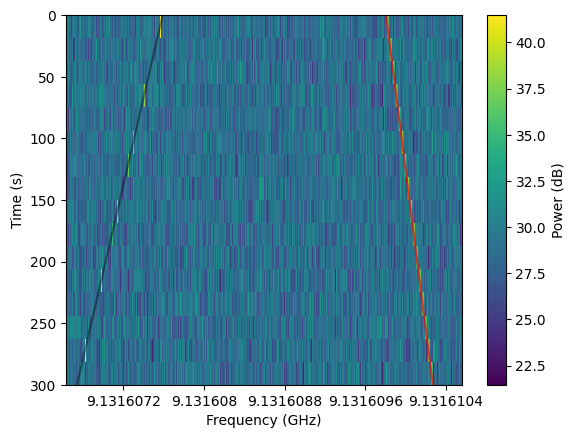

signal = array([ 9.12979111,  0.48498083, 55.94775251])
Closest row index: 148
seticore[min_index] = array([  9.12979325,   2.503111  , 196.7603    ])
Minimum L2 distance: 2.1429970438191503e-06


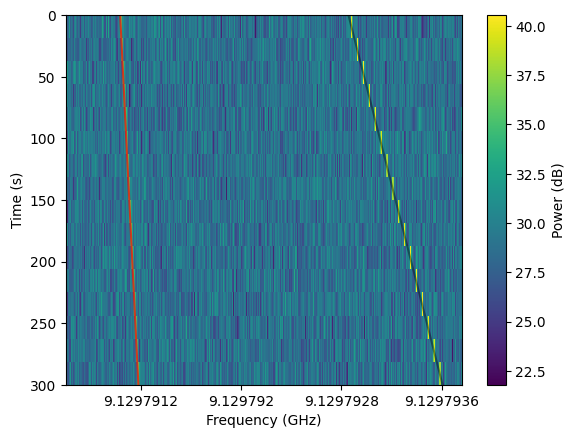

signal = array([ 9.12977458, -3.90802816, 21.41968785])
Closest row index: 149
seticore[min_index] = array([  9.12977625,   4.647111  , 121.959839  ])
Minimum L2 distance: 1.6659700587950965e-06


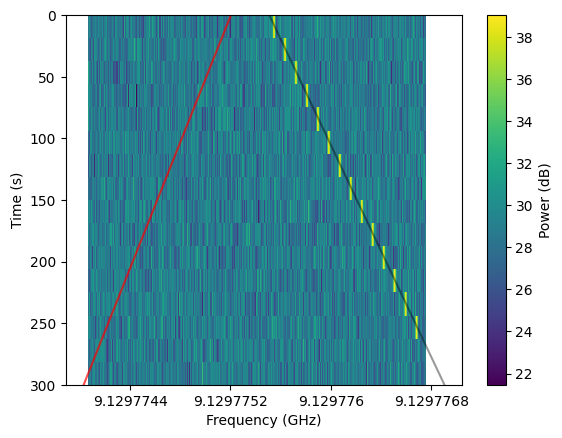

signal = array([ 9.13169025, -4.90788566, 13.5170882 ])
Closest row index: 34
seticore[min_index] = array([  9.13169411,  -1.141333  , 858.043213  ])
Minimum L2 distance: 3.8631928624965894e-06


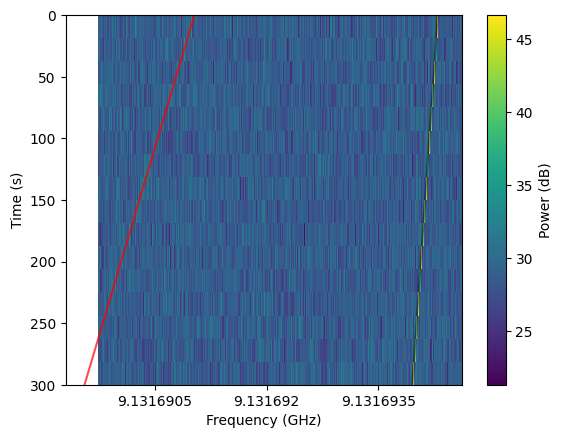

signal = array([ 9.1282213 ,  2.36329528, 88.89468262])
Closest row index: 233
seticore[min_index] = array([   9.12822113,    4.892444  , 1193.604736  ])
Minimum L2 distance: 1.7029041821103874e-07


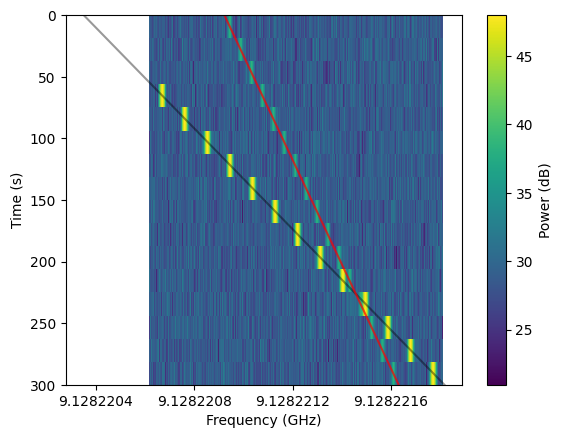

signal = array([ 9.12833511,  0.4881    , 16.96313153])
Closest row index: 226
seticore[min_index] = array([   9.12833556,    4.113778  , 1095.479248  ])
Minimum L2 distance: 4.517659206726421e-07


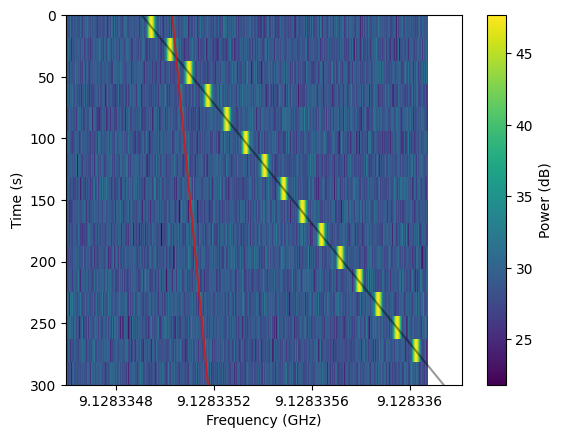

signal = array([  9.12965848,  -2.0744256 , 270.78297904])
Closest row index: 154
seticore[min_index] = array([  9.12965587,  -4.469333  , 790.247986  ])
Minimum L2 distance: 2.610931403523864e-06


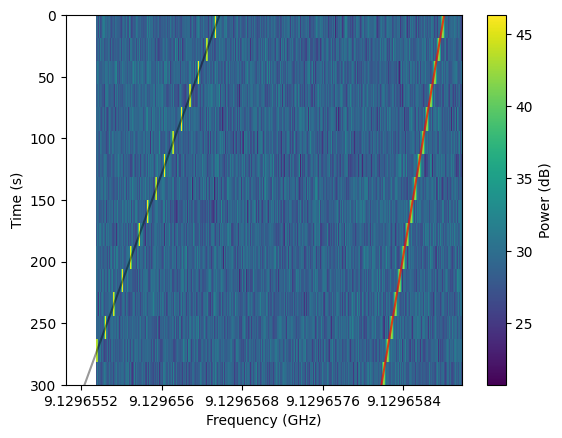

signal = array([  9.13181067,   0.64820746, 210.64341998])
Closest row index: 29
seticore[min_index] = array([  9.13181034,   1.283556  , 277.560944  ])
Minimum L2 distance: 3.276522644313218e-07


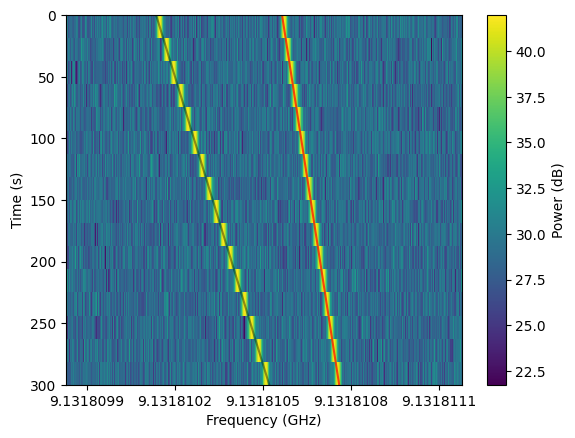

signal = array([ 9.1296708 ,  0.29794715, 19.630875  ])
Closest row index: 152
seticore[min_index] = array([  9.12967178,  -4.352     , 127.869087  ])
Minimum L2 distance: 9.807876537593074e-07


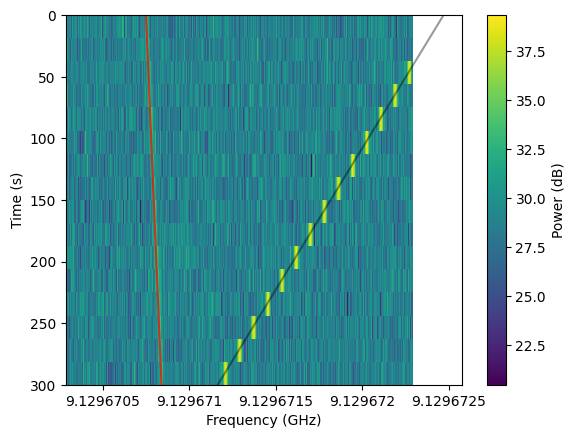

In [601]:
for s in sg:
    if check_signal(s, st_like_sg) > 1e-8:
        check_signal(s, st_like_sg, frame, verbose=True)

## Visualize results

In [623]:
SIGNALS = np.array(SIGNALS)

In [624]:
SIGNALS.shape

(54015, 5)

In [673]:
num_not_found = SIGNALS.shape[0] - SIGNALS[:, 4].sum()
f"{num_not_found = :.0f}, ({100*(num_not_found / SIGNALS.shape[0]) :.3g}%)"

'num_not_found = 4061, (7.52%)'

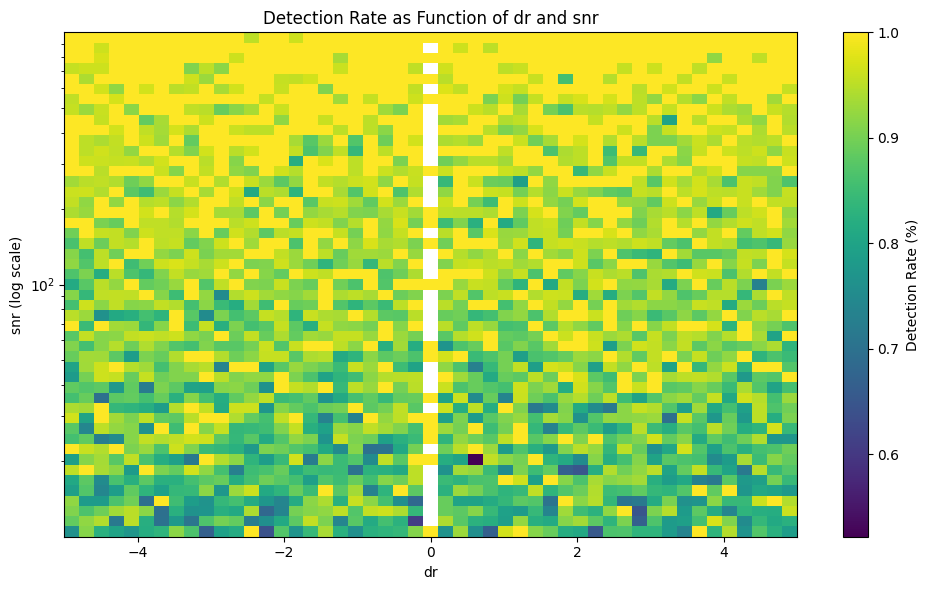

In [674]:
from utils.hist2d import dr_snr, dr_width
dr_snr(SIGNALS)

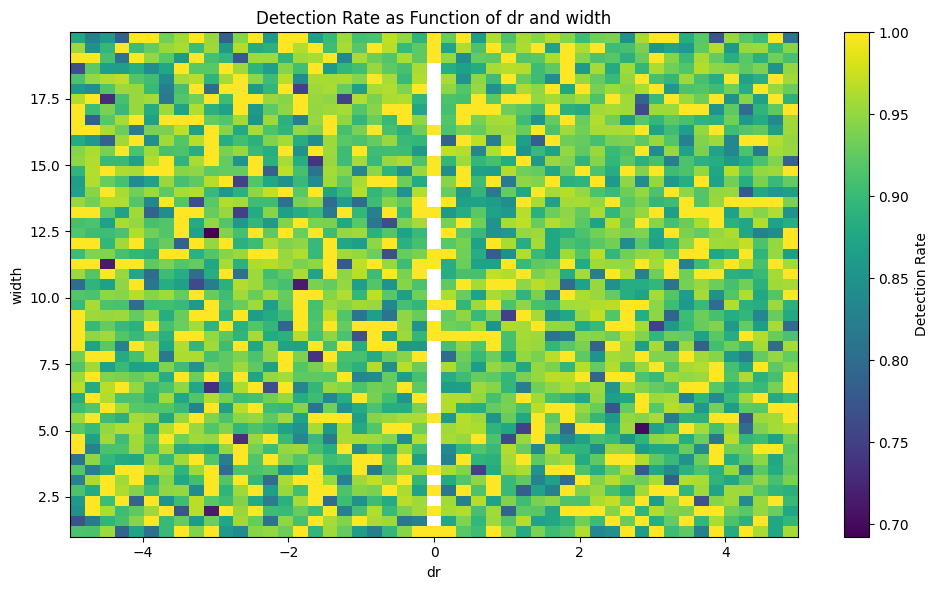

In [675]:
dr_width(SIGNALS)

## Fixed SNR=50

In [13]:
out_dir = Path(TEST_OUTPUT)

files_dir = out_dir / "snr-50"
seticore_dir = out_dir / "seticore-snr-50"
signal_dir = out_dir / "signals-snr-50"

In [14]:
SIGNALS=[]

In [15]:
for file in files_dir.iterdir():
    process_file(file)

In [16]:
SIGNALS = np.array(SIGNALS)
SIGNALS.shape

(246300, 5)

In [17]:
num_not_found = SIGNALS.shape[0] - SIGNALS[:, 4].sum()
f"{num_not_found = :.0f}, ({100*(num_not_found / SIGNALS.shape[0]) :.3g}%)"

'num_not_found = 16194, (6.57%)'

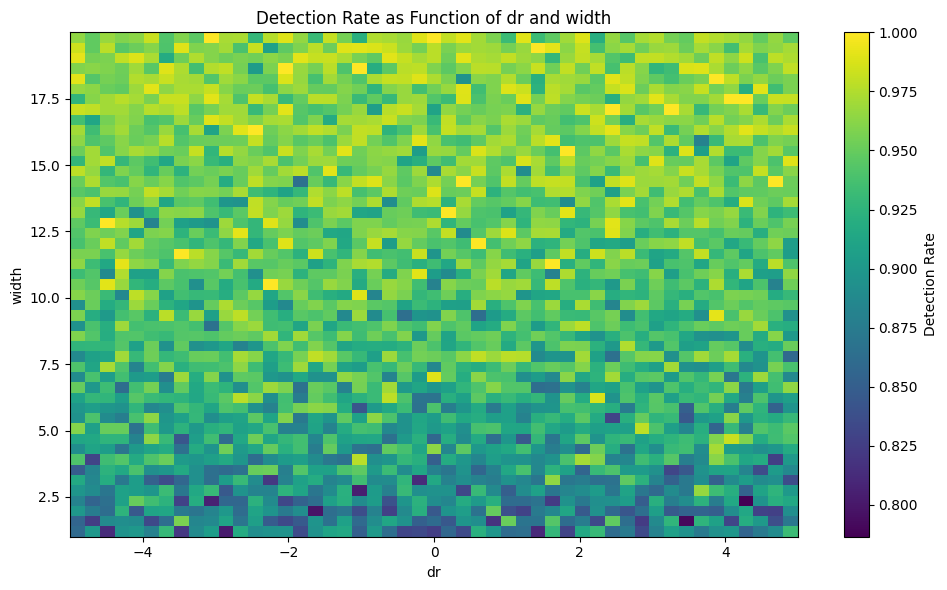

In [18]:
from utils.hist2d import dr_snr, dr_width
dr_width(SIGNALS)

### bigger width range

First i'll try with the snr fixed to 50 again, and then with random SNR. I will need a lot of data to try and show a gradient correctly.
#### Fixed SNR = 50

In [249]:
importlib.reload(utils.setigen)

<module 'utils.setigen' from '/datax/users/obs/osea/seticore/python/utils/setigen.py'>

In [4]:
from utils.setigen import make_and_save_random

In [ ]:
make_and_save_random(
    num_cpus=16,
    signal_per_file=100,
    output_dir=test_output + "width-wide-snr-50/",
    signal_info_dir=test_output + "signals-width-wide-snr-50/",
    1 * uwidth=[.hz, 1 * u.khz],
    snr=50,
    dr=[.01 * (u.hz/u.s), 50 * (u.hz/u.s)], 
    evenly_spaced=True
)

signal = array([ 13.34795936, -35.86908544,  50.        , 920.74193747])
Closest row index: 26
seticore[min_index] = array([ 13.34795939, -36.391111  ,  42.533176  ])
Minimum L2 distance: 2.592668124634656e-08


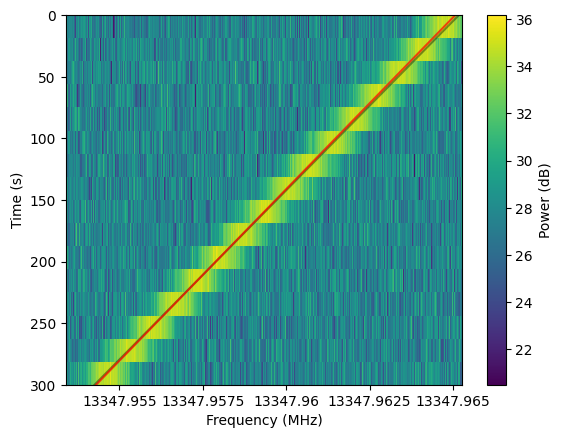

signal = array([ 14.30189613,  11.95096264,  50.        , 236.89265088])
Closest row index: 36
seticore[min_index] = array([14.30187933,  6.101333  , 62.507793  ])
Minimum L2 distance: 1.6805364101202258e-05


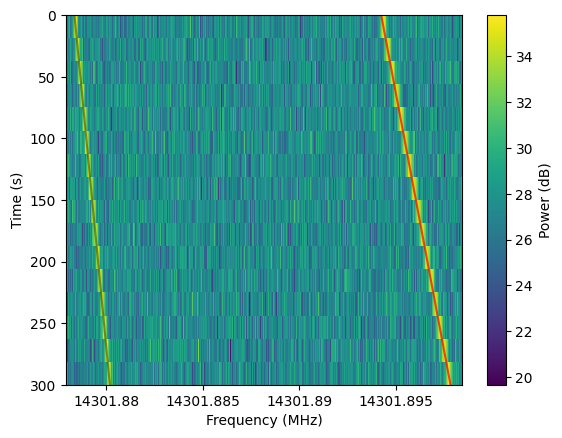

signal = array([  9.23955969,  27.04213831,  50.        , 190.43278944])
Closest row index: 21
seticore[min_index] = array([ 9.23955759, 49.329778  , 63.265842  ])
Minimum L2 distance: 2.0989766493784145e-06


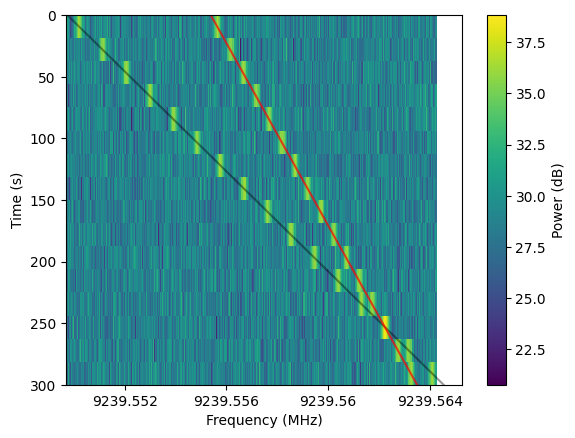

signal = array([  9.80404556,  14.71191372,  50.        , 148.86639696])
Closest row index: 36
seticore[min_index] = array([ 9.80403265, 44.131556  , 62.073795  ])
Minimum L2 distance: 1.2903358165061718e-05


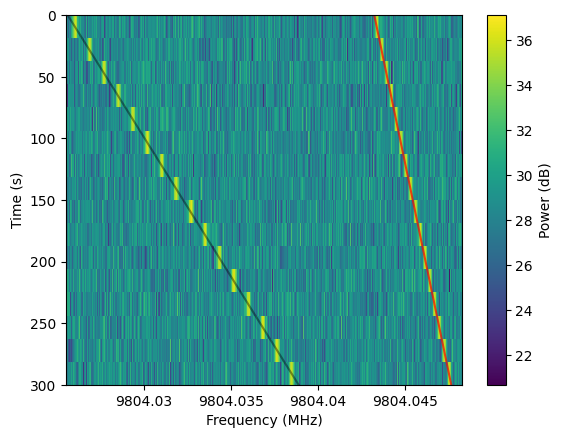

signal = array([12.60711711,  4.24963178, 50.        , 20.15714135])
Closest row index: 8
seticore[min_index] = array([12.60713794, 11.825778  , 58.890732  ])
Minimum L2 distance: 2.083539455099981e-05


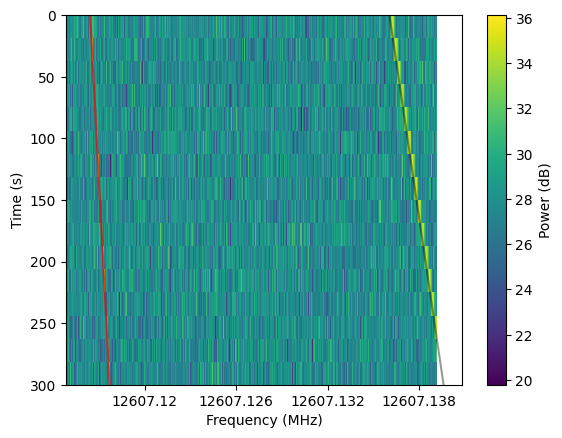

signal = array([12.99235226, 39.27501983, 50.        , 99.47620008])
Closest row index: 2
seticore[min_index] = array([12.99233406, 22.912     , 61.767273  ])
Minimum L2 distance: 1.8203655722359713e-05


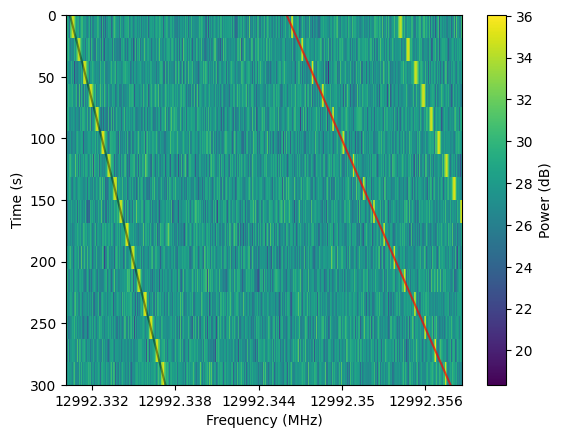

width_wide_snr_50.shape = (453800, 5)
num_not_found = 248214, (54.7%)


In [306]:
out_dir = Path(TEST_OUTPUT)
width_wide_snr_50 = process_dir(
    files_dir=out_dir / "width-wide-snr-50",
    seticore_dir=out_dir / "seticore-width-wide-snr-50",
    signal_dir=out_dir / "signals-width-wide-snr-50",
    show_signal_probability=10/1_000_000
)
print(f"{width_wide_snr_50.shape = }")
num_not_found = width_wide_snr_50.shape[0] - width_wide_snr_50[:, 4].sum()
print(f"{num_not_found = :.0f}, ({100*(num_not_found / width_wide_snr_50.shape[0]) :.3g}%)")

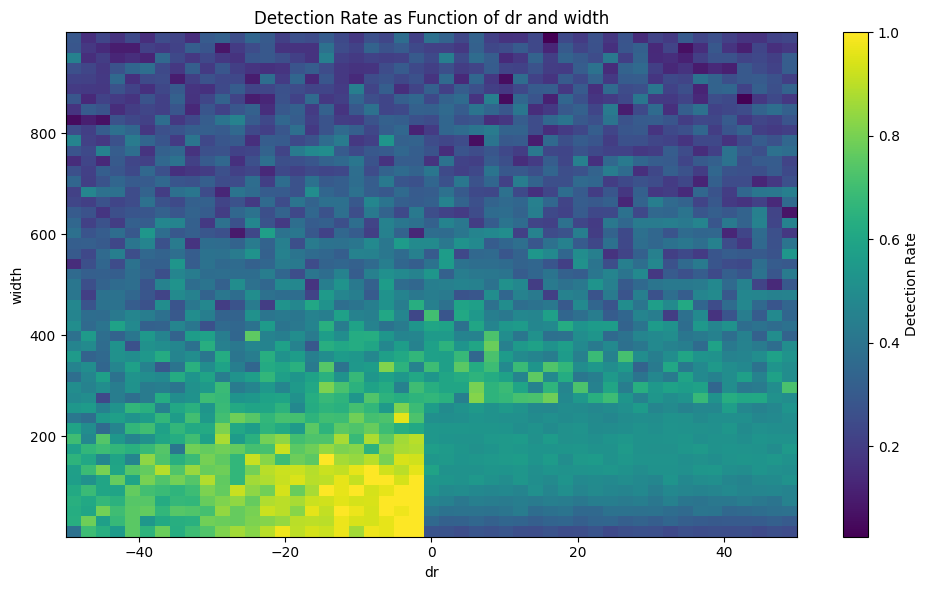

In [308]:
dr_width(width_wide_snr_50, yscale="linear");

In [4]:
import importlib
import utils.setigen
importlib.reload(utils.setigen)
from utils.setigen import make_and_save_random

In [ ]:
make_and_save_random(
    num_cpus=15,
    signal_per_file=100,
    output_dir=TEST_OUTPUT + "ws50.evenly/",
    signal_info_dir=TEST_OUTPUT + "signals-width-wide-snr-50/",
    width=[1 * u.Hz, 250 * u.Hz],
    snr=50,
    dr=[.01 * (u.Hz/u.s), 50 * (u.Hz/u.s)], 
    evenly_spaced=True
)

8387039566898502256.h5 running on process Process-16
1309040982121185628.h5 running on process Process-17
-915946633239292586.h5 running on process Process-18
-2974214153039164971.h5 running on process Process-19
1842387445500569273.h5 running on process Process-20
-3223054493759159736.h5 running on process Process-21
905668781910910155.h5 running on process Process-22
1806515786711854966.h5 running on process Process-23
3074629299889971170.h5 running on process Process-24
4725287513502859187.h5 running on process Process-25
-491066597623289733.h5 running on process Process-26
-559736437211832531.h5 running on process Process-27
-8190593571743761594.h5 running on process Process-28-7197239183891803785.h5 running on process Process-29

7091468843448063289.h5 running on process Process-30
blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for outputs/v2/ws50.evenly/4725287513502859187.h5 without blobbing.
blimpy.waterfall INFO     __write_to_hdf5_light: Writing t

And these are the results I obtain if I don't set the snr fixed to 50
#### Random SNR

In [ ]:
make_and_save_random(
    num_cpus=15,
    signal_per_file=100,
    output_dir=TEST_OUTPUT + "width-wide/",
    signal_info_dir=TEST_OUTPUT + "signals-width-wide/",
    width_fixed=[1 * u.Hz, 1 * u.kHz],
    # snr_fixed=50, # I had forgot this line before, what follows are the plots without this line
    evenly_spaced=True
)

In [138]:
out_dir = Path(TEST_OUTPUT)

files_dir = out_dir / "width-wide"
seticore_dir = out_dir / "seticore-width-wide"
signal_dir = out_dir / "signals-width-wide"

signal = array([ 10.09475603,  -2.4302872 ,  23.03748596, 186.86733431])
Closest row index: 58
seticore[min_index] = array([10.09475603, -2.336     , 32.508972  ])
Minimum L2 distance: 8.268816742429408e-10


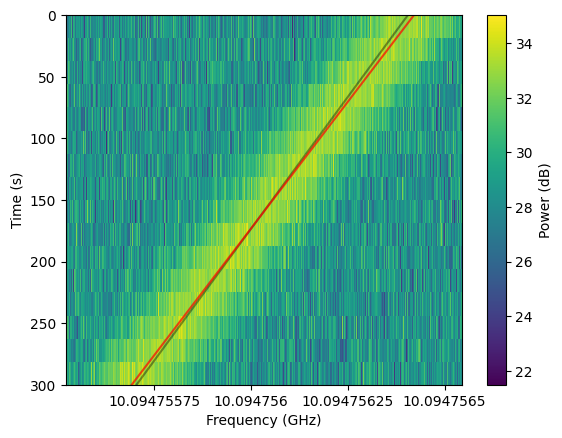

signal = array([  9.52260466,  -4.01198815,  47.15067763, 203.59964331])
Closest row index: 133
seticore[min_index] = array([ 9.52260466, -4.003556  , 61.333115  ])
Minimum L2 distance: 3.9387479944252846e-09


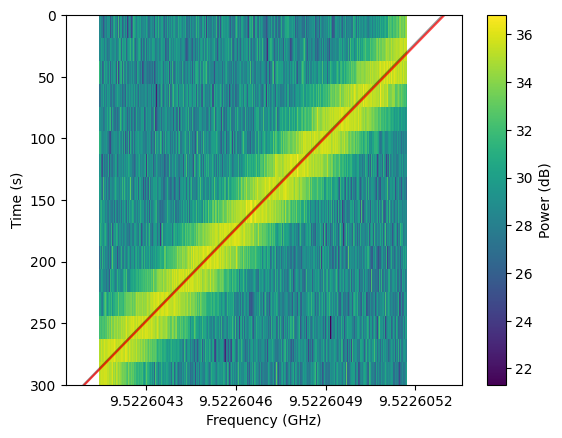

signal = array([ 13.32472597,   0.86454836, 269.97769697, 262.36903021])
Closest row index: 37
seticore[min_index] = array([ 13.32472597,   0.849778  , 332.04776   ])
Minimum L2 distance: 9.351133201107587e-10


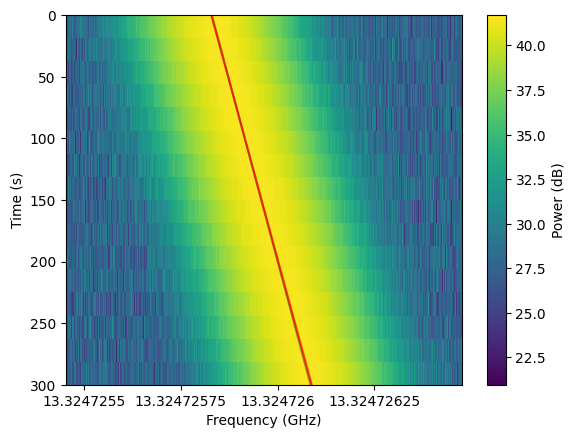

signal = array([  8.30115209,  -3.69346971, 515.51899385,  18.17651905])
Closest row index: 139
seticore[min_index] = array([  8.30115209,  -3.694222  , 619.415283  ])
Minimum L2 distance: 5.193179219986632e-10


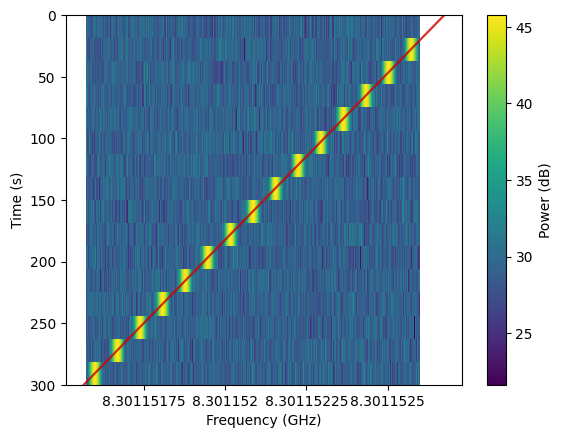

signal = array([  8.70595635,  -1.86007033,  15.68962167, 261.32356274])
Closest row index: 124
seticore[min_index] = array([ 8.70595635, -1.671111  , 23.766993  ])
Minimum L2 distance: 4.13024281442631e-09


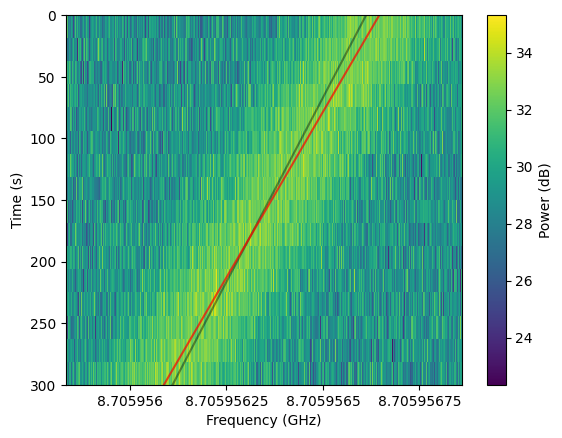

signal = array([ 11.06729175,   3.43713356, 429.04506535, 213.01896251])
Closest row index: 15
seticore[min_index] = array([ 11.06729175,   3.488     , 517.433655  ])
Minimum L2 distance: 3.588045416336172e-10


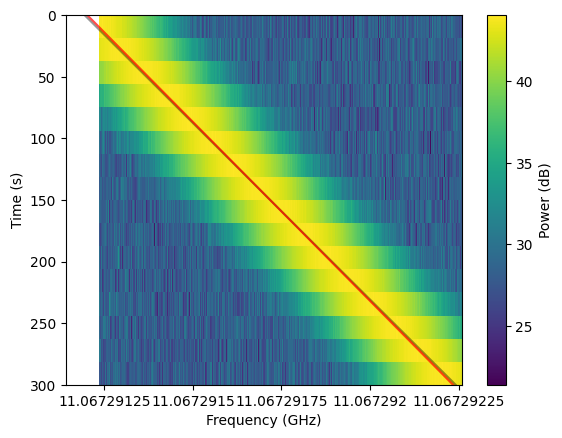

signal = array([ 10.8618828 ,  -1.56916446, 164.12877298, 108.11008872])
Closest row index: 20
seticore[min_index] = array([ 10.8618828,  -1.543111 , 200.413483 ])
Minimum L2 distance: 8.417444519182027e-10


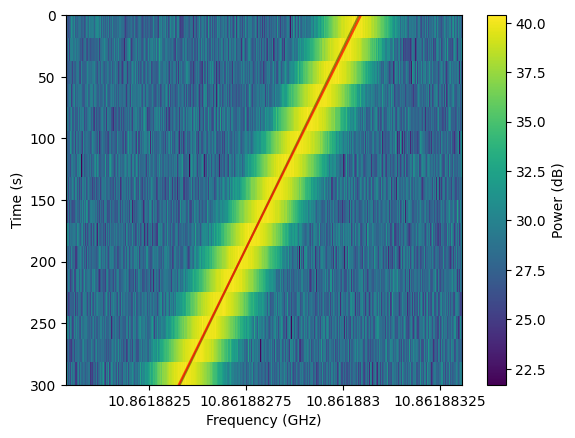

signal = array([  8.9448208 ,   0.78915434, 410.53324691, 296.48235785])
Closest row index: 130
seticore[min_index] = array([  8.9448208,   0.771556 , 495.45163  ])
Minimum L2 distance: 2.2761206253107957e-09


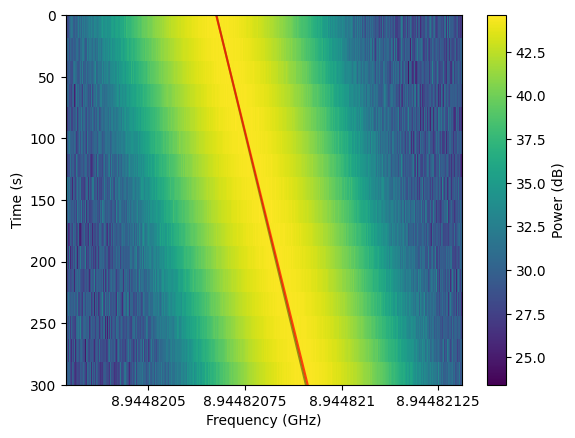

signal = array([ 14.07344747,  -4.30772244, 246.89947037, 387.89989504])
Closest row index: 21
seticore[min_index] = array([ 14.07344746,  -4.305778  , 301.694275  ])
Minimum L2 distance: 6.39299280180694e-09


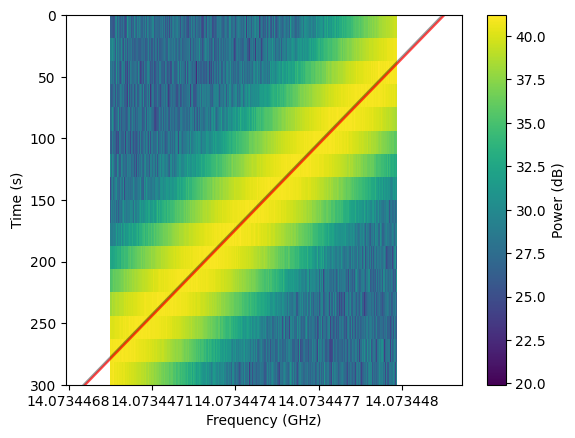

signal = array([ 14.09829178,   2.88861081, 268.58433986,  64.13803976])
Closest row index: 70
seticore[min_index] = array([ 14.09829178,   2.890667  , 324.884766  ])
Minimum L2 distance: 1.1984777614770792e-09


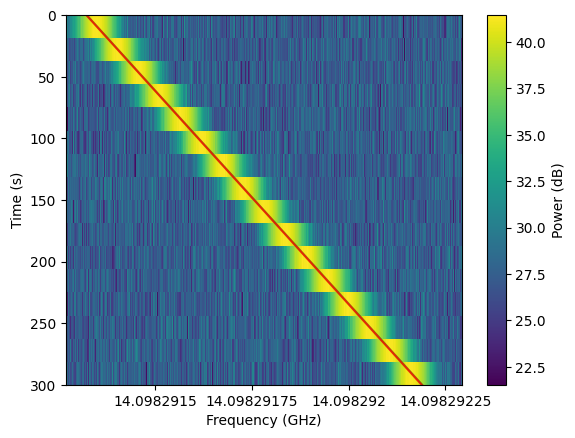

signal = array([ 13.39599149,   1.90939596,  38.66120733, 342.82546535])
Closest row index: 38
seticore[min_index] = array([13.39599149,  1.884444  , 50.554077  ])
Minimum L2 distance: 5.6934581493806036e-09


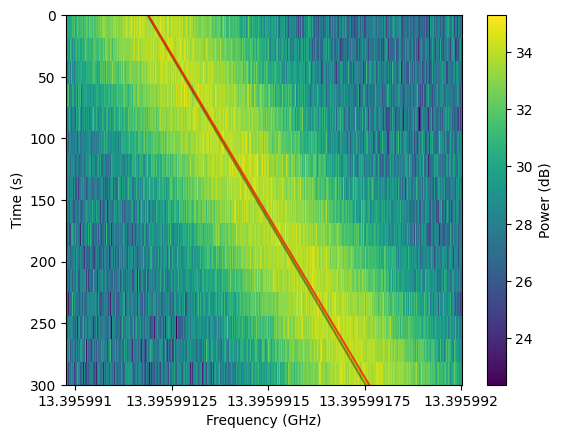

signal = array([ 10.19204099,  -0.88171198, 515.80060959,  85.67701269])
Closest row index: 64
seticore[min_index] = array([ 10.19204099,  -0.896     , 625.548584  ])
Minimum L2 distance: 5.99753136043546e-10


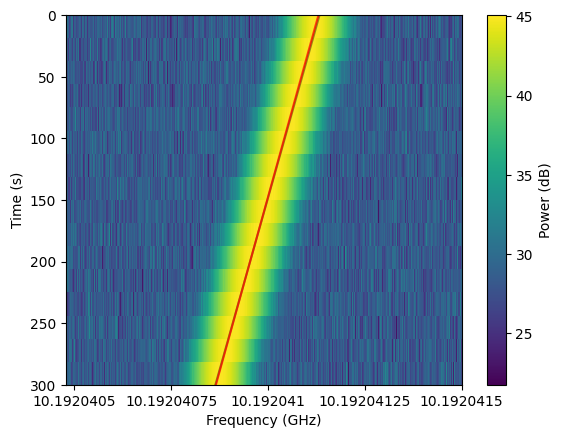

signal = array([ 12.8291817 ,   1.60566482, 279.73437381,  96.56686872])
Closest row index: 11
seticore[min_index] = array([ 12.8291817,   1.592889 , 340.491272 ])
Minimum L2 distance: 6.374865080260861e-10


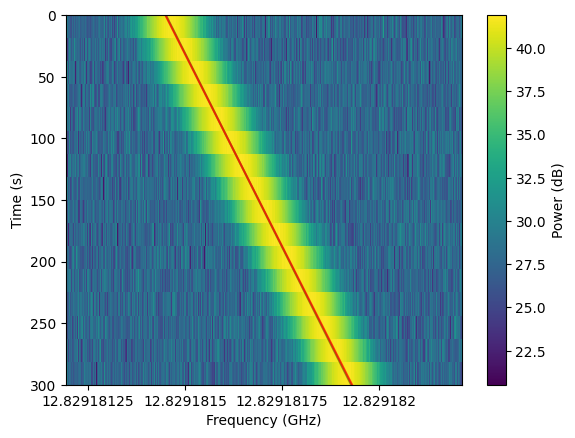

(49000, 5)

In [157]:
SIGNALS = process_dir(
    files_dir=files_dir,
    seticore_dir=seticore_dir,
    signal_dir=signal_dir,
    show_signal_probability=10/49000
)
SIGNALS.shape

In [93]:
num_not_found = SIGNALS.shape[0] - SIGNALS[:, 4].sum()
f"{num_not_found = :.0f}, ({100*(num_not_found / SIGNALS.shape[0]) :.3g}%)"

'num_not_found = 9819, (20%)'

In [100]:
import importlib
import utils.hist2d
importlib.reload(utils.hist2d)

<module 'utils.hist2d' from '/datax/users/obs/osea/seticore/python/utils/hist2d.py'>

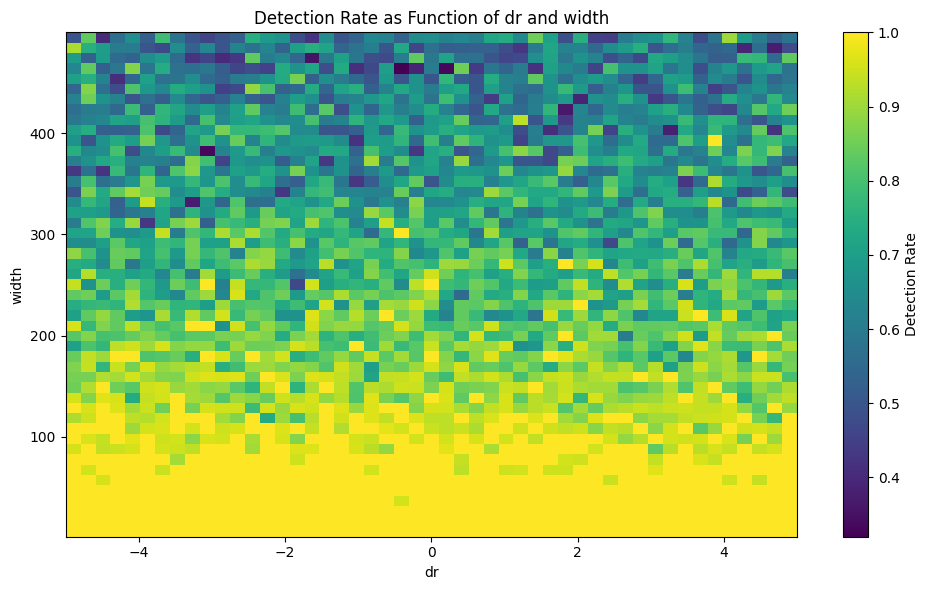

In [103]:
from utils.hist2d import dr_width
dr_width(SIGNALS, yscale='linear')

## Fixed width=1Hz

In [ ]:
make_and_save_random(
    num_cpus=16,
    signal_per_file=100,
    output_dir=TEST_OUTPUT + "width-1Hz/",
    signal_info_dir=TEST_OUTPUT + "signals-width-1Hz/",
    width_fixed=1*u.Hz
)

In [70]:
out_dir = Path(TEST_OUTPUT)

files_dir = out_dir / "width-1Hz"
seticore_dir = out_dir / "seticore-width-1Hz"
signal_dir = out_dir / "signals-width-1Hz"

In [87]:
SIGNALS=[]
process_dir(files_dir, seticore_dir, signal_dir)
SIGNALS = np.array(SIGNALS)
SIGNALS.shape

(141300, 5)

In [88]:
num_not_found = SIGNALS.shape[0] - SIGNALS[:, 4].sum()
f"{num_not_found = :.0f}, ({100*(num_not_found / SIGNALS.shape[0]) :.3g}%)"

'num_not_found = 11109, (7.86%)'

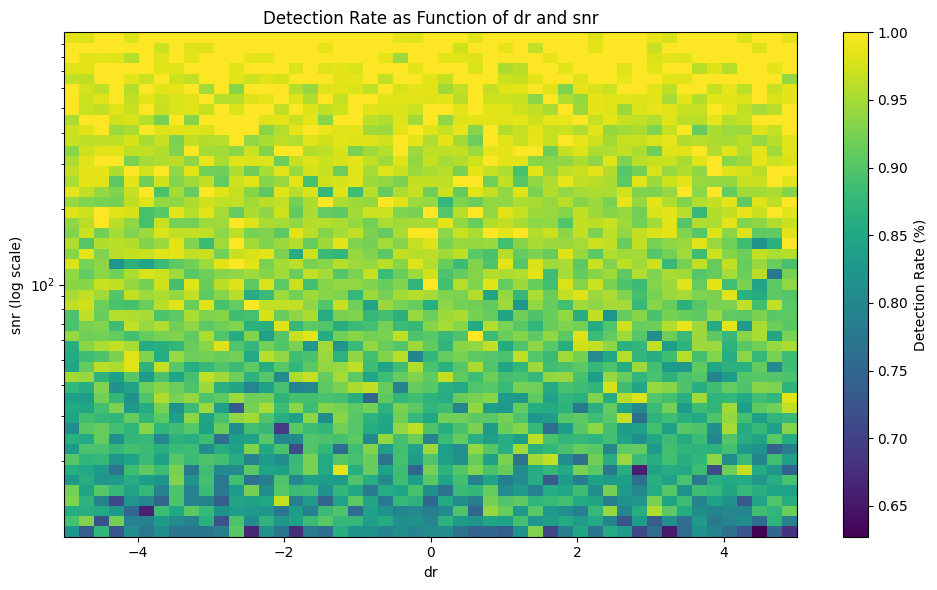

In [89]:
from utils.hist2d import dr_snr
dr_snr(SIGNALS)

## Fixed Adjusted SNR
In order to take into account the width and to properly compare SNR, we need to use the adjusted snr
$$ \text{SNR}_\text{adj} := \text{SNR} \cdot \sqrt{\text{width}} $$
if `adjust_srn` is set to `True`, then the `snr` variable defines $\text{SNR}_\text{adj}$ instead of $\text{SNR}$. The exact implementation is in `utils/setigen.py`

In [243]:
importlib.reload(utils.setigen)
importlib.reload(utils.hist2d)
from utils.setigen import make_and_save_random
from utils.hist2d import *

In [ ]:
make_and_save_random(
    num_cpus=16,
    signal_per_file=100,
    output_dir=TEST_OUTPUT + "wide-snr-50-adj/",
    signal_info_dir=TEST_OUTPUT + "signals-wide-snr-50-adj/",
    width=[1 * u.Hz, 1 * u.kHz],
    snr=50,
    adjust_snr=True,
    dr=[.01 * (u.Hz/u.s), 50 * (u.Hz/u.s)], 
    evenly_spaced=True
)

-4289333733060880596.h5 running on process Process-353
-8497618620579815931.h5 running on process Process-354
7177934455145731131.h5 running on process Process-355
-7186835895929197165.h5 running on process Process-356
-7340918174574941225.h5 running on process Process-357
7040985229541807487.h5 running on process Process-358
-2890568556782067670.h5 running on process Process-359-1311764503916773979.h5 running on process Process-360

8813054206304920912.h5 running on process Process-361
-4813492723740251656.h5 running on process Process-363
8953767394990657994.h5 running on process Process-362
7011561122964144827.h5 running on process Process-364
-3907758761967811039.h5 running on process Process-368
-8139928157707669908.h5 running on process Process-365
1872680717527152894.h5 running on process Process-366
2622162181424629538.h5 running on process Process-367


signal = array([ 10.12262552,   5.66765345,   2.56739588, 379.27509684])
Closest row index: 7
seticore[min_index] = array([10.12262547,  6.574222  ,  9.29488   ])
Minimum L2 distance: 5.31311581397631e-08


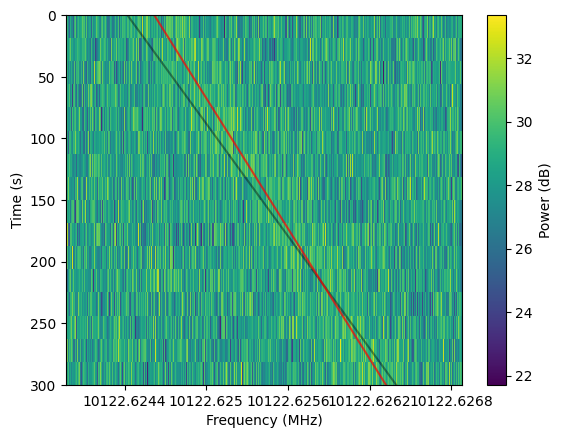

signal = array([ 13.70670411, -37.06316254,   7.27717719,  47.20783776])
Closest row index: 39
seticore[min_index] = array([ 13.70670412, -37.048889  ,  13.507751  ])
Minimum L2 distance: 5.445992101726915e-09


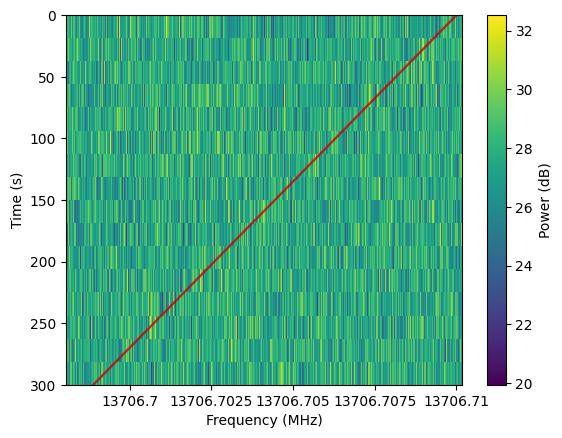

signal = array([ 11.41080874, -16.71081773,   8.01897168,  38.87788666])
Closest row index: 19
seticore[min_index] = array([ 11.41080873, -16.739556  ,  15.097157  ])
Minimum L2 distance: 6.010941078216092e-09


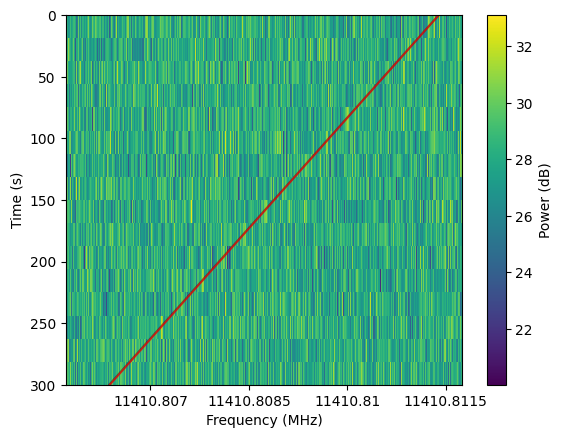

signal = array([ 11.74011089,  31.77608204,   1.82138846, 753.58951451])
Closest row index: 27
seticore[min_index] = array([ 11.74006905, -41.895111  ,   9.709659  ])
Minimum L2 distance: 4.183945035052261e-05


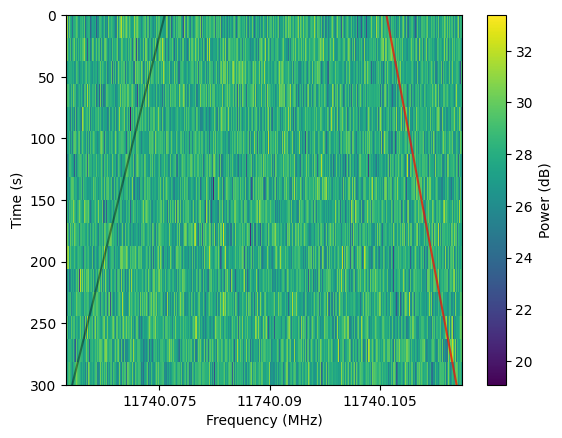

signal = array([  9.83425371,   1.6150975 ,   1.65750572, 909.97599531])
Closest row index: 30
seticore[min_index] = array([ 9.83426165, 39.761778  ,  9.244958  ])
Minimum L2 distance: 7.944798385395302e-06


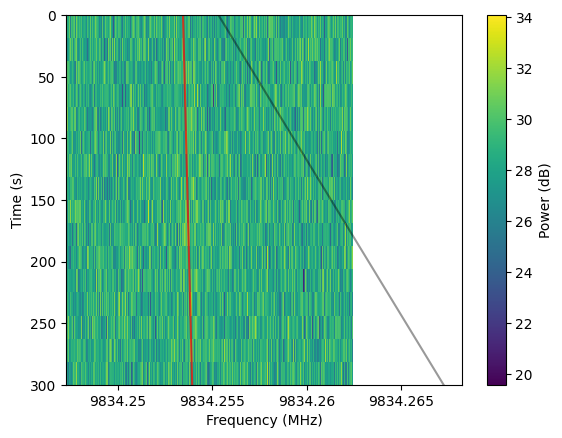

signal = array([ 13.1449871 , -20.76849379,   3.28366765, 231.85775192])
Closest row index: 53
seticore[min_index] = array([ 13.14498711, -21.084444  ,   9.658666  ])
Minimum L2 distance: 1.0320251320194984e-08


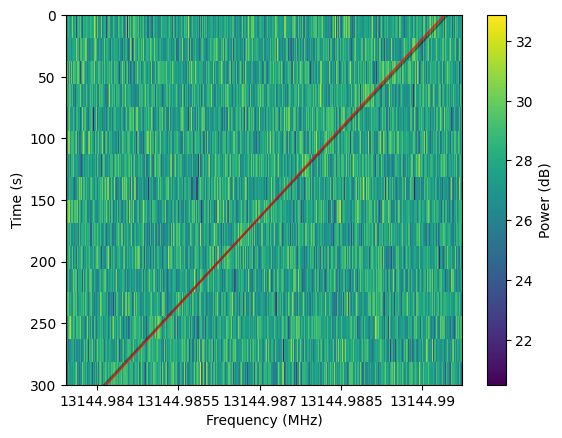

signal = array([ 10.43900418,   9.17353984,   2.42482738, 425.18541223])
Closest row index: 57
seticore[min_index] = array([ 10.43898228, -36.526222  ,   9.465505  ])
Minimum L2 distance: 2.19046167000414e-05


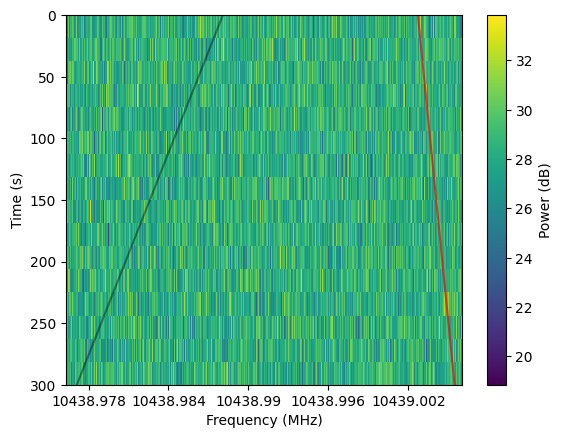

signal = array([ 13.89528207,  27.10210636,   2.68975637, 345.5525629 ])
Closest row index: 5
seticore[min_index] = array([13.89529735, 52.092444  ,  9.245699  ])
Minimum L2 distance: 1.5278959001108205e-05


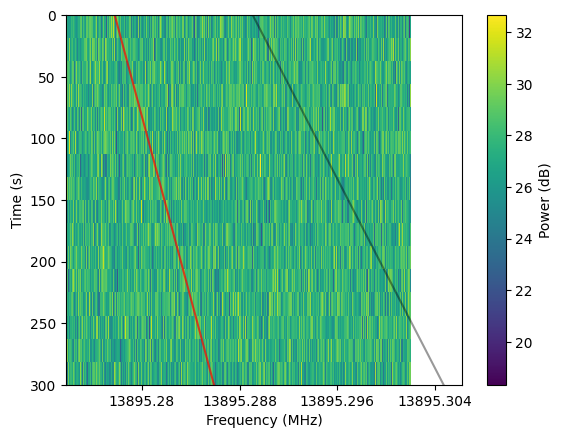

signal = array([ 10.72262449,  25.61417484,   4.7776809 , 109.52310022])
Closest row index: 43
seticore[min_index] = array([10.72262448, 25.511111  , 11.407571  ])
Minimum L2 distance: 1.1266404698062615e-08


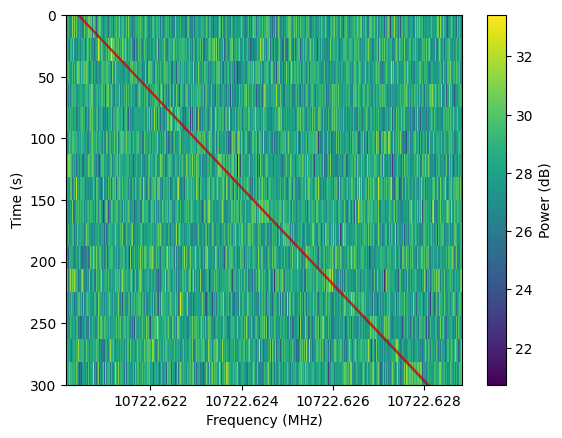

signal = array([  9.90833276, -41.69152417,   2.41062889, 430.20880565])
Closest row index: 43
seticore[min_index] = array([  9.9083327, -41.397333 ,   9.246625 ])
Minimum L2 distance: 5.8626943300055245e-08


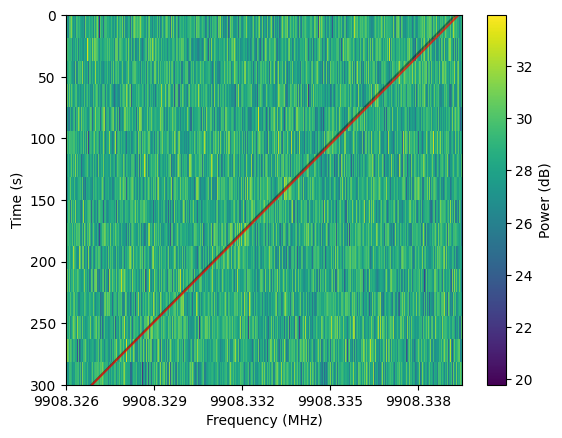

signal = array([ 15.18936904,  13.84007002,   1.81652345, 757.63144109])
Closest row index: 9
seticore[min_index] = array([15.1893506, 37.550222 ,  9.361195 ])
Minimum L2 distance: 1.8441085495979337e-05


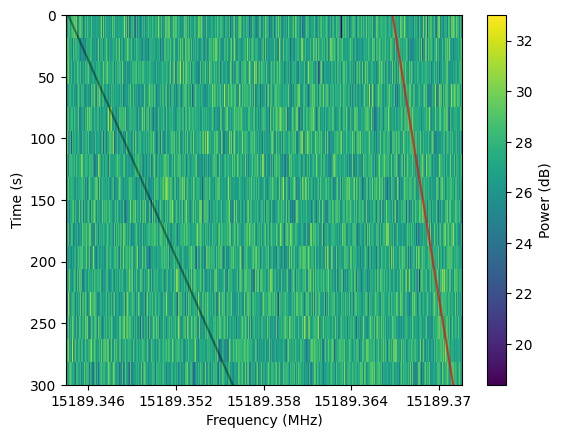

signal = array([ 15.05536934,  33.50424092,   1.63131287, 939.43228668])
Closest row index: 35
seticore[min_index] = array([ 15.05532738, -46.812444  ,  10.690421  ])
Minimum L2 distance: 4.19612077955378e-05


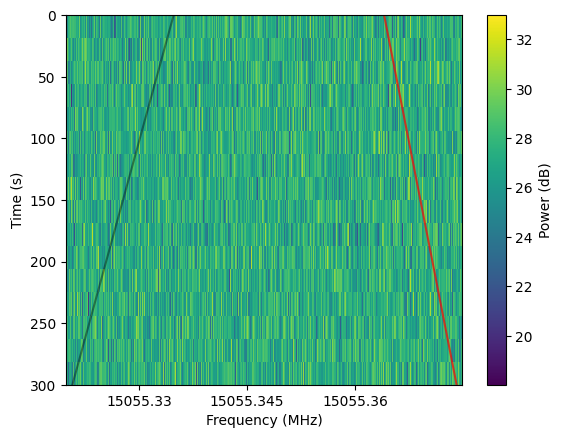

signal = array([ 10.45181499,  47.70716142,   2.65243681, 355.34476139])
Closest row index: 46
seticore[min_index] = array([10.45181499, 48.696889  ,  9.148775  ])
Minimum L2 distance: 6.3651306447809475e-09


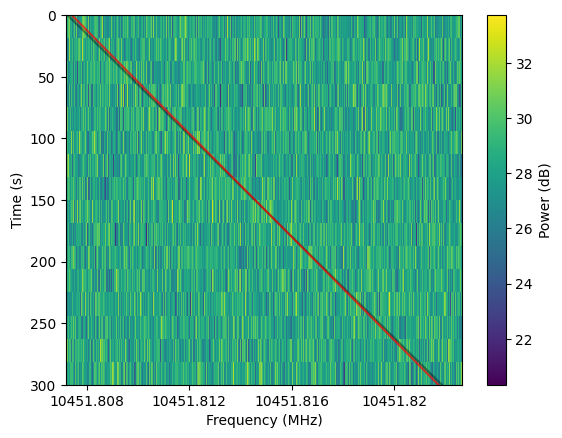

wide_snr_50_adj.shape = (99500, 5)
num_not_found = 83933, (84.4%)


In [245]:
out_dir = Path(TEST_OUTPUT)
wide_snr_50_adj = process_dir(
    files_dir=out_dir / "wide-snr-50-adj",
    seticore_dir=out_dir / "seticore-wide-snr-50-adj",
    signal_dir=out_dir / "signals-wide-snr-50-adj",
    show_signal_probability=10/80_000
)
print(f"{wide_snr_50_adj.shape = }")
num_not_found = wide_snr_50_adj.shape[0] - wide_snr_50_adj[:, 4].sum()
print(f"{num_not_found = :.0f}, ({100*(num_not_found / wide_snr_50_adj.shape[0]) :.3g}%)")

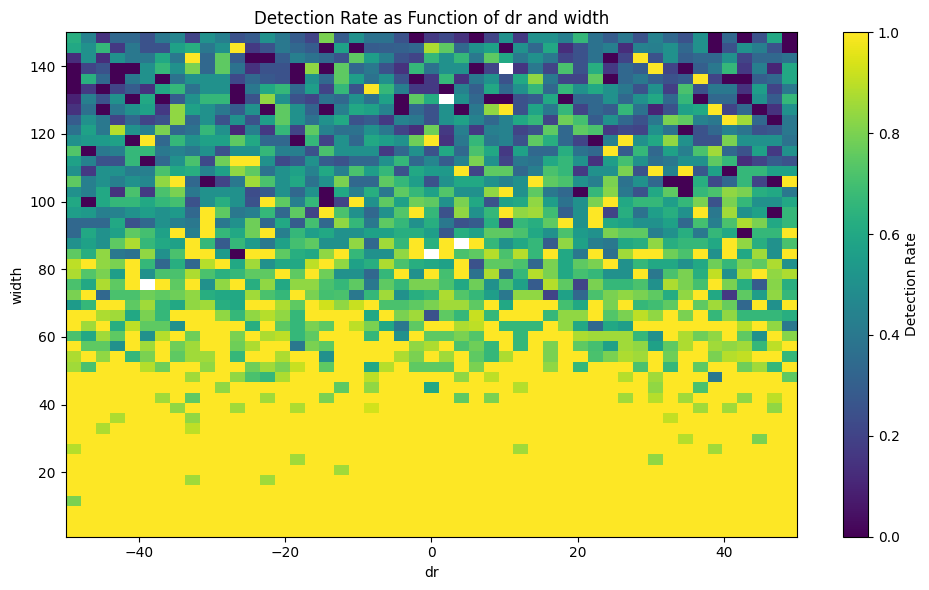

In [246]:
dr_width(wide_snr_50_adj, yscale="linear", ylim=[1, 150])